In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['JAX_JIT_PJIT_API_MERGE'] = '0'
import logging
from copy import deepcopy
import numpy as np
from numpy import pi
from qiskit.circuit import Gate
from qiskit import transpile
from qiskit.transpiler import InstructionProperties
import sys
sys.path.append('../')
from qiskit_utilities import (
    save_job_data,
    setup_logger,
    retrieve_expdata,
    get_cr_schedule,
    iy_drag_calibration,
    get_default_cr_params,
    read_calibration_data,
    iterative_cr_pulse_calibration,
    create_echoed_cr_schedule,
    initilize_qiskit_dynamics_backend,
    create_echoed_cnot_schedule,
    parallel_cr_pulse_calib,
    parallel_iy_drag_calibration
)
from qiskit_ibm_runtime import QiskitRuntimeService
token = "REPLACE WITH IBM TOKEN"
service = QiskitRuntimeService(
    token=token,
    channel="ibm_quantum"
)
backend = service.backend("ibm_rensselaer")
setup_logger(filename=None, level=logging.INFO, stdout=True)
logger = logging.getLogger("qiskit_utilities")

2024-10-30 09:53:28,059, MainThread 
INFO Logger initialized successfully.


In [3]:
qubit_pairs = [[0,1], [3,4]]
initial_calibration_data = []
for qubit_pair in qubit_pairs:
    cr_config, ix_config = get_default_cr_params(backend, qubit_pair[0], qubit_pair[1])
    duration = backend.defaults().instruction_schedule_map.get("ecr", 
                        (qubit_pair[0], qubit_pair[1])).duration/16*4
    cr_params  = {
        "duration": int(duration),
        "sigma": 64,
        "amp": cr_config['amp'],
        "angle": cr_config['angle'],
        # "angle": 0,
    }
    ix_params = {
        "duration": int(duration),
        "sigma": 64,
        "amp": ix_config['amp'],
        # "amp": 0.5,
        "angle": ix_config['angle'],
    }
    initial_calibration = {
        "cr_params": cr_params,
        "ix_params": ix_params,
        "frequency_offset": 0,
    }
    initial_calibration_data.append(initial_calibration)
cr_times = 16 * np.arange(16, duration + 16, duration//30, dtype=int)
gate_name = "CR-default"

In [3]:
parallel_cr_pulse_calib(
    qubits=qubit_pairs,
    backend=backend,
    initial_calibration_data=initial_calibration_data,
    cr_times=cr_times,
    gate_name=gate_name,
    verbose=True,
    restart=True,
    threshold_MHz=0.015,
    max_repeat=3,
    shots=512,
    mode="CR"
)

2024-10-25 17:08:50,926, MainThread 
INFO Target IX / ZX ratio: 0.0
2024-10-25 17:08:50,927, MainThread 
INFO 

CR calibration round 1: 
2024-10-25 17:08:51,273, MainThread 
INFO Generated 192 tomography circuits.
2024-10-25 17:09:23,397, MainThread 
INFO CR-tomo: cwdx1bx543p00085qkdgcwdx1d50r6b0008p0k10cwdx1ed31we00087azmgcwdx1fx543p00085qkf0
backend: <IBMBackend('ibm_rensselaer')>
qubit_pairs: [[0, 1], [3, 4]]
cr_times: [  256   640  1024  1408  1792  2176  2560  2944  3328  3712  4096  4480
  4864  5248  5632  6016  6400  6784  7168  7552  7936  8320  8704  9088
  9472  9856 10240 10624 11008 11392 11776 12160]
shots: 512
cr_params: [{'duration': 12160, 'sigma': 64, 'amp': 0.29948044899261234, 'angle': 1.5211550598654648}, {'duration': 12160, 'sigma': 64, 'amp': 0.3287265481225294, 'angle': 0.4867999347450592}]
ix_params: [{'duration': 12160, 'sigma': 64, 'amp': 0.038675724556711005, 'angle': 0.0030647307236930125}, {'duration': 12160, 'sigma': 64, 'amp': 0.03219570367030035, 'angle

ValueError: cannot reshape array of size 1 into shape (32,6)

/scr/dataset/yuchen/qec_calib/Calib_Compiler/qiskit_utilities/cr_pulse.py:1091: OptimizeWarning: Covariance of the parameters could not be estimated
  params, cov = curve_fit(fun, tlist, data, p0=p0, maxfev=10000)


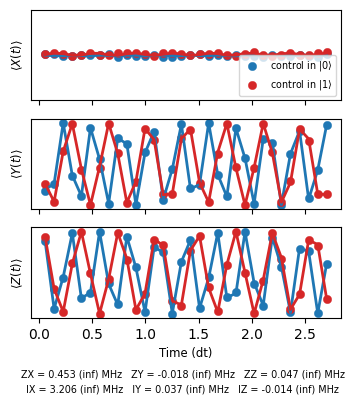

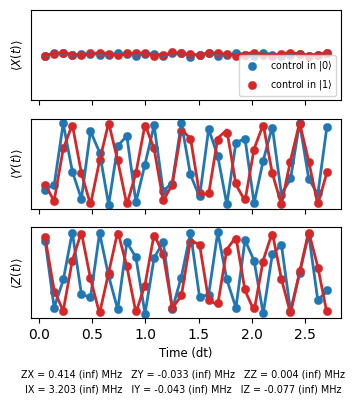

[{'IX': 3.2062614402361382,
  'IY': 0.03728695113270831,
  'IZ': -0.014447822095157704,
  'ZX': 0.45287259300449906,
  'ZY': -0.018277962551165074,
  'ZZ': 0.04709154012768102},
 {'IX': 3.2031071756845577,
  'IY': -0.042630574484813354,
  'IZ': -0.0774477346041042,
  'ZX': 0.4137076348225988,
  'ZY': -0.03311319836530045,
  'ZZ': 0.004463111620223735}]

In [1]:
from qiskit_utilities import  process_parallel_tomo_data
jobs = ["cwdx1bx543p00085qkdg", "cwdx1d50r6b0008p0k10", "cwdx1ed31we00087azmg", "cwdx1fx543p00085qkf0"]
process_parallel_tomo_data(jobs, show_plot=True)

In [4]:
gate_name = "CR-default"
calibration_data = read_calibration_data(backend, gate_name, (3, 4))
custom_cr_schedule = create_echoed_cr_schedule(backend, (3, 4), calibration_data, parallel_exp=True)

[  256   640  1024  1408  1792  2176  2560  2944  3328  3712  4096  4480
  4864  5248  5632  6016  6400  6784  7168  7552  7936  8320  8704  9088
  9472  9856 10240 10624 11008 11392 11776 12160]
4834.312167932607 9668.625336942718
4.589837367889496e-10 13585.60702242457


2024-10-25 16:40:47,655, MainThread 
WARNING The estimated CR pulse time is different for control qubit in state 0 and 1. This indicate that the ZX interaction strength is not well calibrated.


4.589837367889496e-10 13585.60702242457


/scr/dataset/yuchen/qec_calib/Calib_Compiler/qiskit_utilities/cr_pulse.py:1091: OptimizeWarning: Covariance of the parameters could not be estimated
  params, cov = curve_fit(fun, tlist, data, p0=p0, maxfev=10000)


PulseError: 'Assigned parameters duration=-5088, sigma=64, width=-5344.0, amp=0.3287265481225294, angle=0.49319443552481296 violate following constraint: And(0 < sigma, 0 <= width, width <= duration).'

2024-10-23 02:16:25,040, MainThread 
INFO 
Calibrating the IY-DRAG pulse for [92, 102]-CR-default.
2024-10-23 02:16:25,043, MainThread 
INFO 
Calibrating the IY-DRAG pulse for [126, 112]-CR-default.
2024-10-23 02:16:25,387, MainThread 
INFO Generated 192 tomography circuits.
2024-10-23 02:16:34,201, MainThread 
INFO CR-tomo: cwc5s0cggr6g00891ns0
backend: <IBMBackend('ibm_rensselaer')>
qubit_pairs: [[92, 102], [126, 112]]
cr_times: [  256   640  1024  1408  1792  2176  2560  2944  3328  3712  4096  4480
  4864  5248  5632  6016  6400  6784  7168  7552  7936  8320  8704  9088
  9472  9856 10240 10624 11008 11392 11776 12160]
shots: 2048
cr_params: [{'duration': 12160, 'sigma': 64, 'amp': 0.21278894076577073, 'angle': -2.4998338884266045}, {'duration': 12160, 'sigma': 64, 'amp': 0.2154624344661316, 'angle': -1.3254821704579605}]
ix_params: [{'duration': 12160, 'sigma': 64, 'amp': 0.004571727105716882, 'angle': -0.005822367939087588, 'beta': 0.0}, {'duration': 12160, 'sigma': 64, 'amp': -0

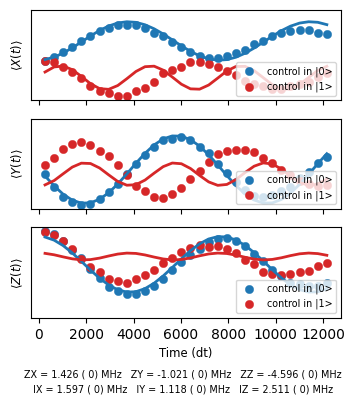

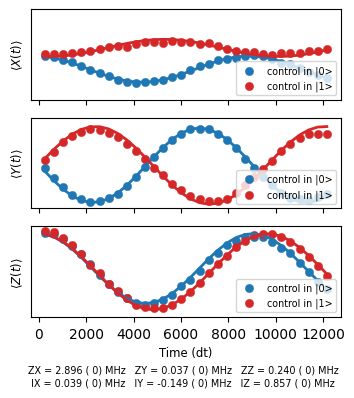

2024-10-23 02:21:04,222, MainThread 
INFO Generated 192 tomography circuits.
2024-10-23 02:21:12,704, MainThread 
INFO CR-tomo: cwc5v5w9ezk000893xcg
backend: <IBMBackend('ibm_rensselaer')>
qubit_pairs: [[92, 102], [126, 112]]
cr_times: [  256   640  1024  1408  1792  2176  2560  2944  3328  3712  4096  4480
  4864  5248  5632  6016  6400  6784  7168  7552  7936  8320  8704  9088
  9472  9856 10240 10624 11008 11392 11776 12160]
shots: 1024
cr_params: [{'duration': 12160, 'sigma': 64, 'amp': 0.21278894076577073, 'angle': -2.4998338884266045}, {'duration': 12160, 'sigma': 64, 'amp': 0.2154624344661316, 'angle': -1.3254821704579605}]
ix_params: [{'duration': 12160, 'sigma': 64, 'amp': 0.004571727105716882, 'angle': -0.005822367939087588, 'beta': -100.0}, {'duration': 12160, 'sigma': 64, 'amp': -0.0019694846316635466, 'angle': 0.0984641117076506, 'beta': -100.0}]
x_gate_ix_params: [None, None]
frequency_offset: [-65662.16199476866, 159241.64881602334]
dt: 2.2222222222222221e-10

2024-10-23

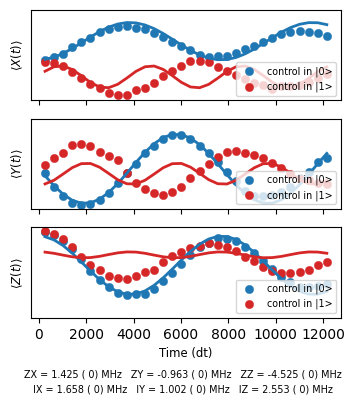

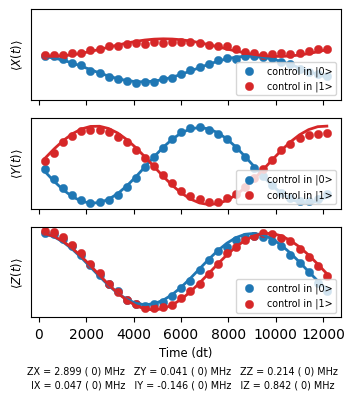

2024-10-23 02:25:39,981, MainThread 
INFO Generated 192 tomography circuits.
2024-10-23 02:25:50,234, MainThread 
INFO CR-tomo: cwc5xbdjyrs0008x22w0
backend: <IBMBackend('ibm_rensselaer')>
qubit_pairs: [[92, 102], [126, 112]]
cr_times: [  256   640  1024  1408  1792  2176  2560  2944  3328  3712  4096  4480
  4864  5248  5632  6016  6400  6784  7168  7552  7936  8320  8704  9088
  9472  9856 10240 10624 11008 11392 11776 12160]
shots: 1024
cr_params: [{'duration': 12160, 'sigma': 64, 'amp': 0.21278894076577073, 'angle': -2.4998338884266045}, {'duration': 12160, 'sigma': 64, 'amp': 0.2154624344661316, 'angle': -1.3254821704579605}]
ix_params: [{'duration': 12160, 'sigma': 64, 'amp': 0.004571727105716882, 'angle': -0.005822367939087588, 'beta': 100.0}, {'duration': 12160, 'sigma': 64, 'amp': -0.0019694846316635466, 'angle': 0.0984641117076506, 'beta': 100.0}]
x_gate_ix_params: [None, None]
frequency_offset: [-65662.16199476866, 159241.64881602334]
dt: 2.2222222222222221e-10

2024-10-23 0

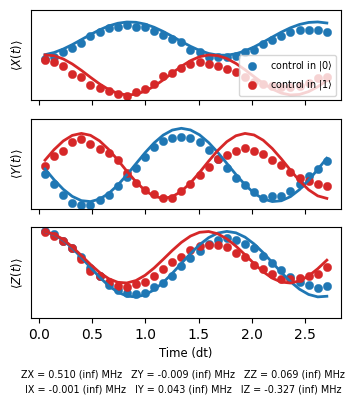

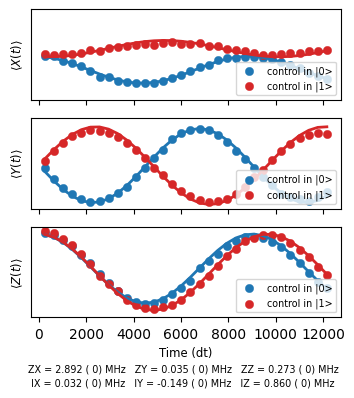

2024-10-23 02:30:18,982, MainThread 
INFO ZZ sampling measurements complete : [[-4.59593807  0.23953131]
 [-4.52539963  0.214145  ]
 [ 0.06876796  0.27328339]].



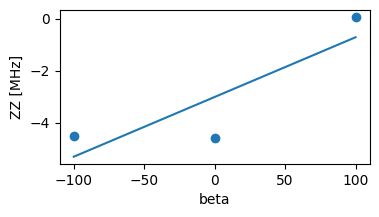

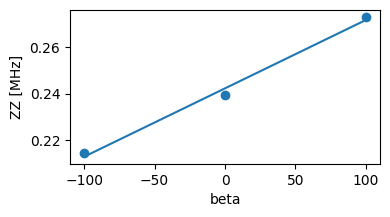

2024-10-23 02:30:19,085, MainThread 
INFO Calibrated IY beta: [131.36321944672693, -819.5012185607532]

2024-10-23 02:30:19,669, MainThread 
INFO Generated 192 tomography circuits.
2024-10-23 02:30:29,287, MainThread 
INFO CR-tomo: cwc5zh69ezk000893xw0
backend: <IBMBackend('ibm_rensselaer')>
qubit_pairs: [[92, 102], [126, 112]]
cr_times: [  256   640  1024  1408  1792  2176  2560  2944  3328  3712  4096  4480
  4864  5248  5632  6016  6400  6784  7168  7552  7936  8320  8704  9088
  9472  9856 10240 10624 11008 11392 11776 12160]
shots: 2048
cr_params: [{'duration': 12160, 'sigma': 64, 'amp': 0.21278894076577073, 'angle': -2.4998338884266045}, {'duration': 12160, 'sigma': 64, 'amp': 0.2154624344661316, 'angle': -1.3254821704579605}]
ix_params: [{'duration': 12160, 'sigma': 64, 'amp': 0.004571727105716882, 'angle': -0.005822367939087588, 'beta': 131.36321944672693}, {'duration': 12160, 'sigma': 64, 'amp': -0.0019694846316635466, 'angle': 0.0984641117076506, 'beta': -819.5012185607532}]


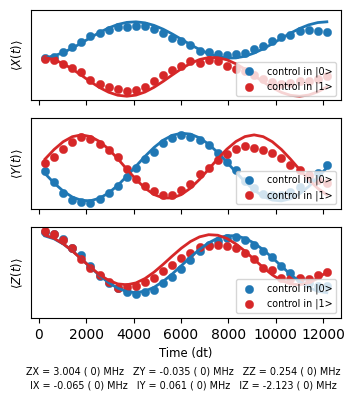

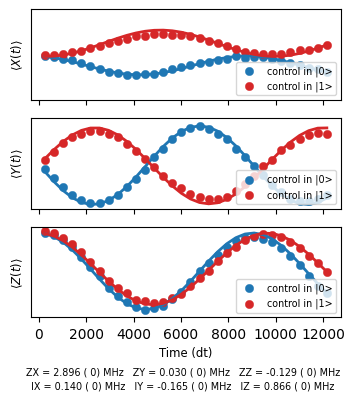

2024-10-23 02:34:58,702, MainThread 
INFO Updated coupling strength: [{'IX': -0.0646360176526437, 'IY': 0.061346943207050954, 'IZ': -2.1227133170183015, 'ZX': 3.003540193006886, 'ZY': -0.03520971282387104, 'ZZ': 0.25364218014822015}, {'IX': 0.14048917441199427, 'IY': -0.1652135335974831, 'IZ': 0.8663202350344781, 'ZX': 2.8957894153409303, 'ZY': 0.030378311188837423, 'ZZ': -0.12874801091491223}]
2024-10-23 02:34:58,704, MainThread 
WARNING Frequency offset larger than 2MHz, update is not applied. Please check if the fit is accurate.
2024-10-23 02:34:58,708, MainThread 
INFO Frequency offset is updated to -273918.4687012157 Hz


In [3]:
parallel_iy_drag_calibration(
    qubit_pairs=qubit_pairs,
    backend=backend,
    gate_name=gate_name,
    cr_times=cr_times,
    verbose=True,
)